# LegoIzer

A tool to play around with images to create lego mosaic

### References / useful material
* https://rebrickable.com/downloads/
* 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cv2
from pypxl import process_frame
from utils import string_to_rgb
import numpy as np
import scipy

# import skimage
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
# !pip list

### Process colors file

In [175]:
colors_file = "../data/colors.xml"
df_colors = pd.read_xml(colors_file)
df_colors.set_index('COLOR')

df_colors.drop([0], inplace=True)
df_colors = df_colors[['COLOR','COLORNAME','COLORRGB']]
# print(len(df_colors))

# df_colors.drop_duplicates(subset=['rgb'], keep='first', inplace=True)
print(len(df_colors))

201


In [177]:
df_colors['rgb_'] = df_colors['COLORRGB'].apply(lambda x: string_to_rgb(x))
df_colors['lab_'] = df_colors['rgb_'].apply(lambda x: tuple(cv2.cvtColor(np.uint8([[x]]), cv2.COLOR_RGB2LAB)[0][0].tolist()))

### Process image

In [179]:
fn = "../images/pic1.jpg"
im_in = cv2.imread(fn, cv2.IMREAD_COLOR)
print(im_in.shape)

(768, 768, 3)


(768, 768, 3)


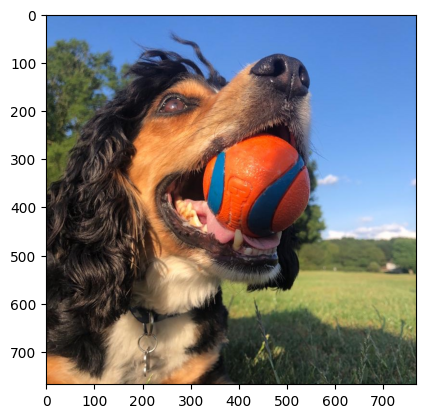

In [180]:
RGB_im_orig = cv2.cvtColor(im_in, cv2.COLOR_BGR2RGB)
print(RGB_im_orig.shape)
plt.imshow(RGB_im_orig)

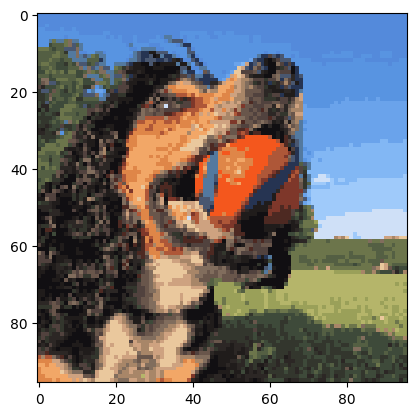

In [181]:
num_clusters = 30

n_accross = 3
n_down = n_accross
base_size = 32
lego_unit_mm = 1.6    # lego measure in units of 1.6mm
size_11_mm = 5 * 1.6  # 1x1 is 5 lego units
cost_per_brick = 0.06 # from pick-a-brick

size_0 = n_accross*base_size
size_1 = n_down*base_size

# prescale_size = (128,128)
prescale_size = None

im_out = process_frame(im_in, 
                       size_0, 
                       size_1, 
                       num_clusters, 
                       prescale_size,
                       False
                      )

RGB_im = cv2.cvtColor(im_out, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_im);

In [145]:
# illuminants = ['D50', 'D55', 'D65']
# LAB_im = skimage.color.rgb2lab(RGB_im, illuminant='D65')

In [146]:
# my_dpi = 40
# 
# v = RGB_im[0,0,:]
# v = cv2.cvtColor(np.uint8([[v]]), cv2.COLOR_RGB2BGR)[0][0].tolist()
# swatch = np.zeros((21,21,3), np.uint8)
# swatch = cv2.circle(swatch, (10,10), 10, v, -1)
# plt.figure(figsize = (20/my_dpi,20/my_dpi))
# plt.axis('off')
# plt.imshow(swatch);

In [182]:
# Create the map for this image
im_out_lab = cv2.cvtColor(im_out, cv2.COLOR_BGR2LAB)
unique_cols_lab = np.unique(im_out_lab.reshape(-1,3), axis=0).tolist()

col_list = df_colors['lab_'].values.tolist()
col_map = {}

for c_lab in unique_cols_lab:
    closest_index = scipy.spatial.distance.cdist([c_lab], 
                                                 col_list, 
                                                 metric='euclidean').argmin()
    closest_color = col_list[closest_index]
    # print(c_lab, closest_index, col_list[closest_index])
    col_map[tuple(c_lab)] = closest_color

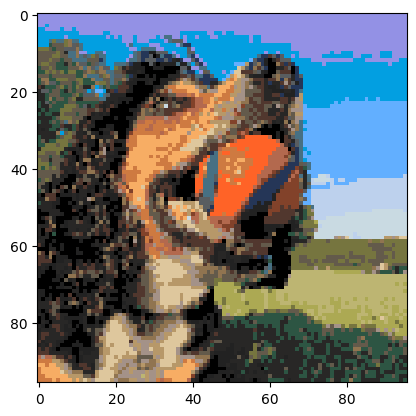

In [183]:
# Apply map to the image
w,h = im_out.shape[:2]
im_out_flat = im_out_lab.reshape(-1,3)

nearest_flat = np.array([col_map[tuple(x)] for x in im_out_flat])
nearest = nearest_flat.astype(np.uint8).reshape((h,w,3))

im_final = cv2.cvtColor(nearest, cv2.COLOR_LAB2RGB)
plt.imshow(im_final);

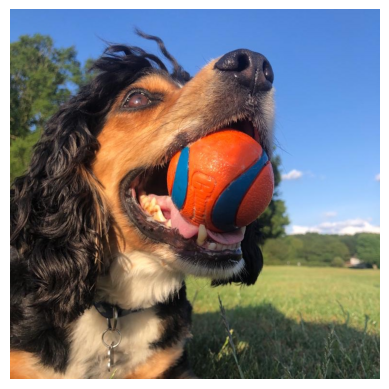

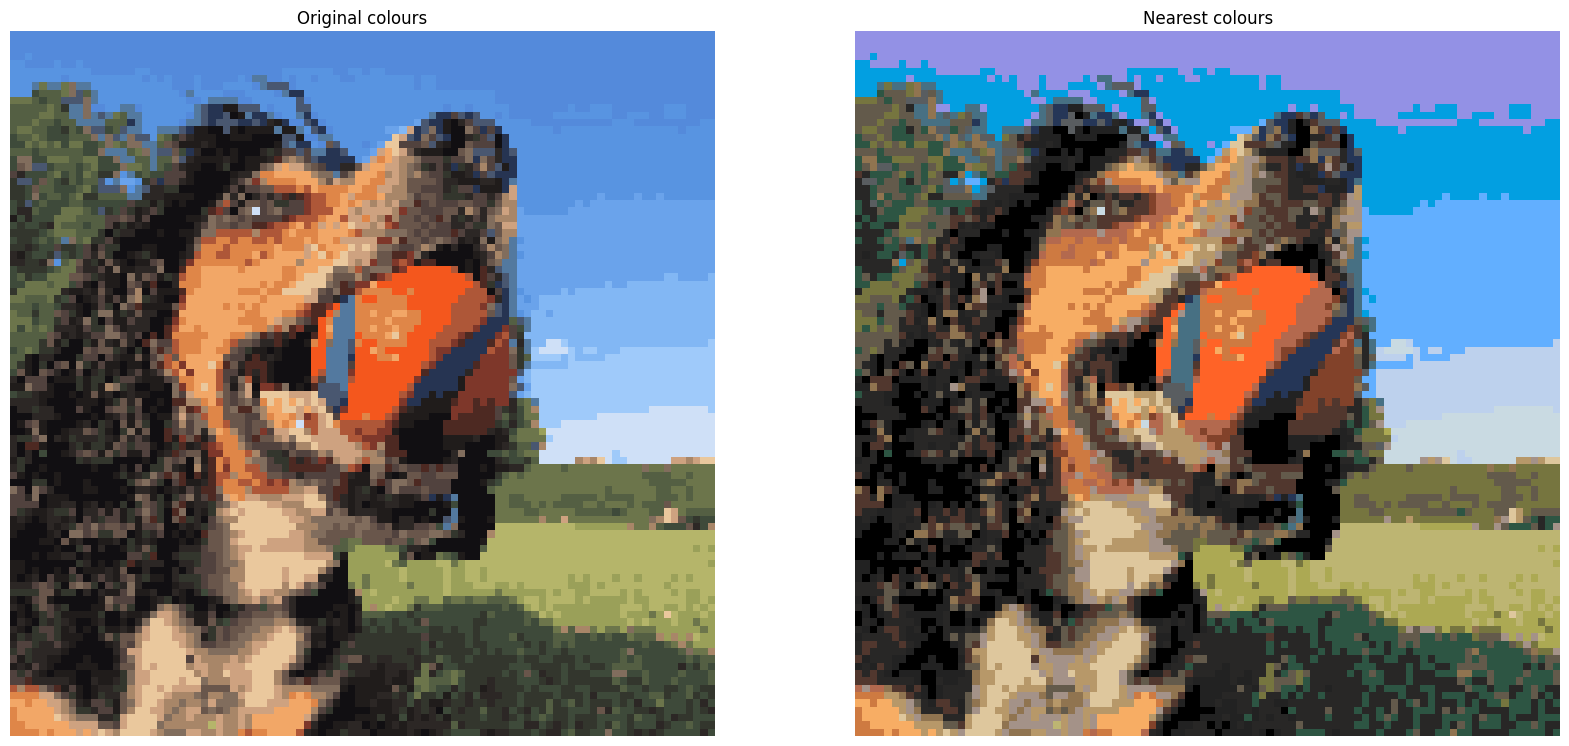

Number of colors: 30
Number of bricks: 9216
Size in mm: w=768.0, h=768.0
Estimated total cost £92.16


In [184]:
plt.imshow(RGB_im_orig)
plt.axis('off')

fig,axs = plt.subplots(1,2)
fig.set_figwidth(20)
fig.set_figheight(30)

axs[0].imshow(RGB_im)
axs[0].set_aspect('equal', 'box')
axs[0].axis('off')
axs[0].set_title('Original colours')

axs[1].imshow(im_final)
axs[1].set_aspect('equal', 'box')
axs[1].axis('off')
axs[1].set_title('Nearest colours')

plt.show()
print(f'Number of colors: {len(col_map)}')
print(f'Number of bricks: {np.prod(im_final.shape[:2])}')
print(f'Size in mm: w={w*size_11_mm}, h={h*size_11_mm}')
print(f'Estimated total cost £{np.prod(im_final.shape[:2])/100:.2f}')

In [185]:
bricks,counts = np.unique(nearest.reshape(-1,3), axis=0, return_counts=True)

In [189]:
v1 = tuple(map(tuple, bricks))
v2 = counts.tolist()
df_bricks_needed = pd.DataFrame({'lab_':v1, 'MINQTY':v2})

In [200]:
df_final = df_colors.merge(df_bricks_needed, on='lab_', how='inner')

In [202]:
# Prepare for writing XML
df_final['ITEMTYPE'] = 'P'
df_final['ITEMID'] = '3204'

In [201]:
df_final.head(5)

,COLOR,COLORNAME,COLORRGB,rgb_,lab_,MINQTY
0,11,Black,212121,"(33, 33, 33)","(33, 128, 128)",560
1,105,Bright Light Blue,BCD1ED,"(188, 209, 237)","(212, 127, 112)",214
2,153,Dark Azure,009FE0,"(0, 159, 224)","(158, 117, 85)",629
3,63,Dark Blue,243757,"(36, 55, 87)","(58, 132, 106)",116
4,85,Dark Bluish Gray,595D60,"(89, 93, 96)","(100, 127, 126)",94


In [196]:
fn_out = '../data/bricks.xml'

In [204]:
df_final.to_xml(fn_out, 
                elem_cols=['ITEMTYPE','ITEMID','COLOR','MINQTY'],  
                index=False, 
                root_name='INVENTORY', 
                row_name='ITEM', 
                xml_declaration=False
               )